# Battery Analysis

This jupyter file contains simple analysis of the Nasa dataset, which partly follows/converts the `R` code that was given included with the dataset

In [1]:
# Import important libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dataframe_image as dfi
from scipy import io
from datetime import datetime

## Loading the `.mat` data with python

In [2]:
BATTERY = 'RW10' # other batteries include RW10, RW11, RW12
battery_path = f'battery datasets/1.Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post/data/Matlab/{BATTERY}.mat'
mat = io.loadmat(battery_path, simplify_cells=True)

## The structure of the dataset

This is how the data may look like, there're 3 different types of reference profiles: `C` (charge), `D` (discharge), and `R` (rest).

There's also 15 different `comment`s, with describe how these 3 profiles were performed. 

In [3]:
df = pd.DataFrame(mat['data']['step'])

# df.drop_duplicates(subset=['comment']).sort_values('type').head()

## Example Plots of Low Current Discharge Cycles

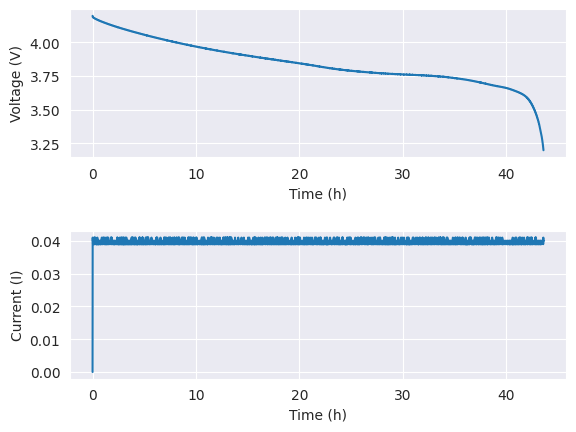

In [4]:
%matplotlib inline
df = pd.DataFrame(mat['data']['step'])
df = df.query('comment == "low current discharge at 0.04A"')

time_hour = df.iloc[0]['relativeTime'] / 3600
voltage = df.iloc[0]['voltage']
current = df.iloc[0]['current']

sns.set_style("darkgrid")
plt.subplot(2, 1, 1)
sns.lineplot(x=time_hour, y=voltage)
plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')

plt.subplot(2, 1, 2)
sns.lineplot(x=time_hour, y=current)
plt.xlabel('Time (h)')
plt.ylabel('Current (I)')

plt.subplots_adjust(hspace=0.5)
plt.show()

## The **reference discharge profile**

Is is a cycle consisting of a cycle of fully discharging the the battery when the voltage is the maxiumum.

This cycle will act as our ground truth, eg. used for computing the **capacity** and thus **SoH**. 

Below is a plot of showing how the voltage charging becomes slower for each cycle

> Lightest = first cycle
> 
> Darkest = last cycle

## Example of how the reference discharge current may look like

/tmp/ipykernel_42453/2512475626.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sm)


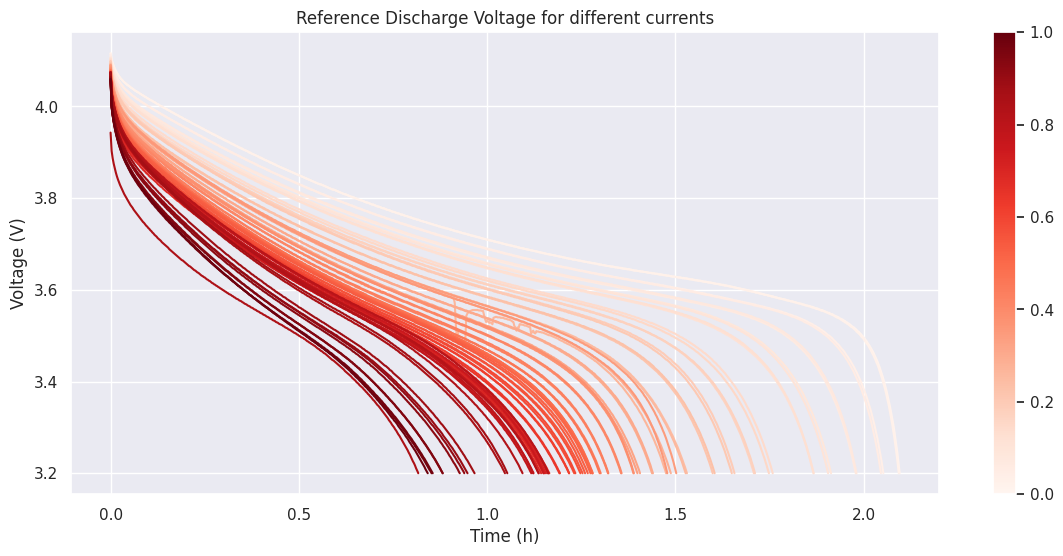

In [5]:
%matplotlib inline
df = pd.DataFrame(mat['data']['step'])
df = df.query('comment == "reference discharge"')
df = df[['relativeTime', 'voltage']]

sns.set(rc={"figure.figsize":(14, 6)}) 
sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("Reds", n_colors=len(df)))
cmap = sns.color_palette("Reds", n_colors=len(df), as_cmap=True)

for index, row in df.iterrows():
    time_hour = row['relativeTime'] / 3600
    voltage = row['voltage']
    sns.lineplot(x=time_hour, y=voltage, linewidth=1.5)


sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm)
plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')
plt.title('Reference Discharge Voltage for different currents')
plt.show()
sns.reset_defaults()


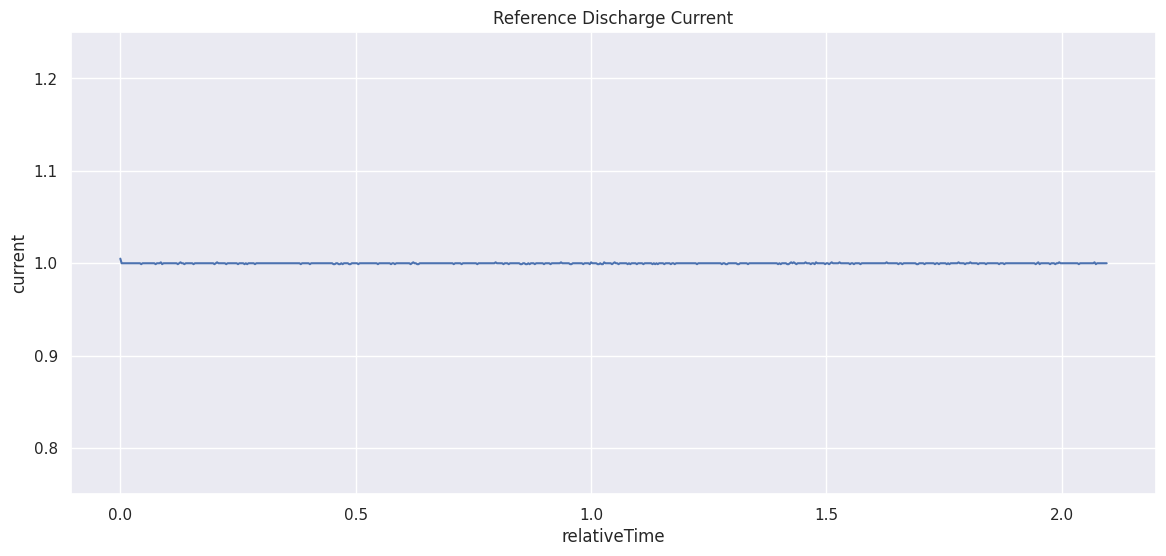

In [6]:
df = pd.DataFrame(mat['data']['step'])
df = df.query('comment == "reference discharge"')
df = df[['relativeTime', 'current']]


temp_dict = {
    'relativeTime': df.iloc[0]['relativeTime'] / 3600,
    'current': df.iloc[0]['current'],
    }
temp_df = pd.DataFrame(temp_dict)

sns.set_style('darkgrid')
sns.set(rc={"figure.figsize":(14, 6)}) 
ax = sns.lineplot(data=temp_df, x='relativeTime', y='current', linewidth=1.5)
ax.set_ylim([0.75, 1.25])
plt.title('Reference Discharge Current')
plt.show()

## Compute the Capacity and SoH with the Reference Discharge

To compute the capacity, one can simple integrate the current (I) over the relative time interval (s) during the reference discharge cycle:

$$Capacity = \int_{t_1}^{t_2} f(t)dt$$
$$t_1 = \text{time when the battery is fully charged}$$ 
$$t_2 = \text{time when the battery is fully discharged}$$


This can be achived using the code below using the `np.trapz()` function to approximate the integral. Futhermore, the SoH is simply computed by:
$$
SoH (Capacity) = \frac{Capacity}{Capacity_{inital}}
$$

In [7]:
format_string = "%d-%b-%Y %H:%M:%S"

df = pd.DataFrame(mat['data']['step'])
df = df.query('comment == "reference discharge"')
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, format_string)) # Change 'date' to the right format 
df['capacity (Ah)'] = [np.trapz(i, t) / 3600 for i, t in zip(df['current'], df['relativeTime'])] # Performing the integration
df['SoH (capacity)'] = df['capacity (Ah)'] /  df['capacity (Ah)'].iloc[0] * 100 # Compute the SoH

### Computing SoH using the resistance

Another definition of SoH is using the resistance (R) where the formula for it is simply:
$$
R = \frac{V}{I}
$$
Thus it's very easy to compute, the code below does it. Consequently the SoH (resistance) can be computed with (**not entirely sure if this is true**):
$$
SoH (resistance) = \frac{R}{R_{initial}}
$$

In [8]:
# Computes the mean voltage and current for each cycle
mean_voltage = df['voltage'].apply(lambda x: np.mean(x)) 
mean_current = df['current'].apply(lambda x: np.mean(x))
# Thus the mean resitance for each cycle can by computed
df['mean resistance'] = mean_voltage / mean_current
# Computing SoH (resistance)
df['SoH (resistance)'] = df['mean resistance'] / df['mean resistance'].iloc[0] * 100

## `refDisSteps.head()` should look something like this

In [9]:
# df.head()

## Plotting capacity, resistance and SoH for both methods
At least looking at the mean resistance for the **reference discharge** cycles, it's highly similar to the capacity. The problem is however that the mean resistance have very high variance for the instances outside the reference charge.

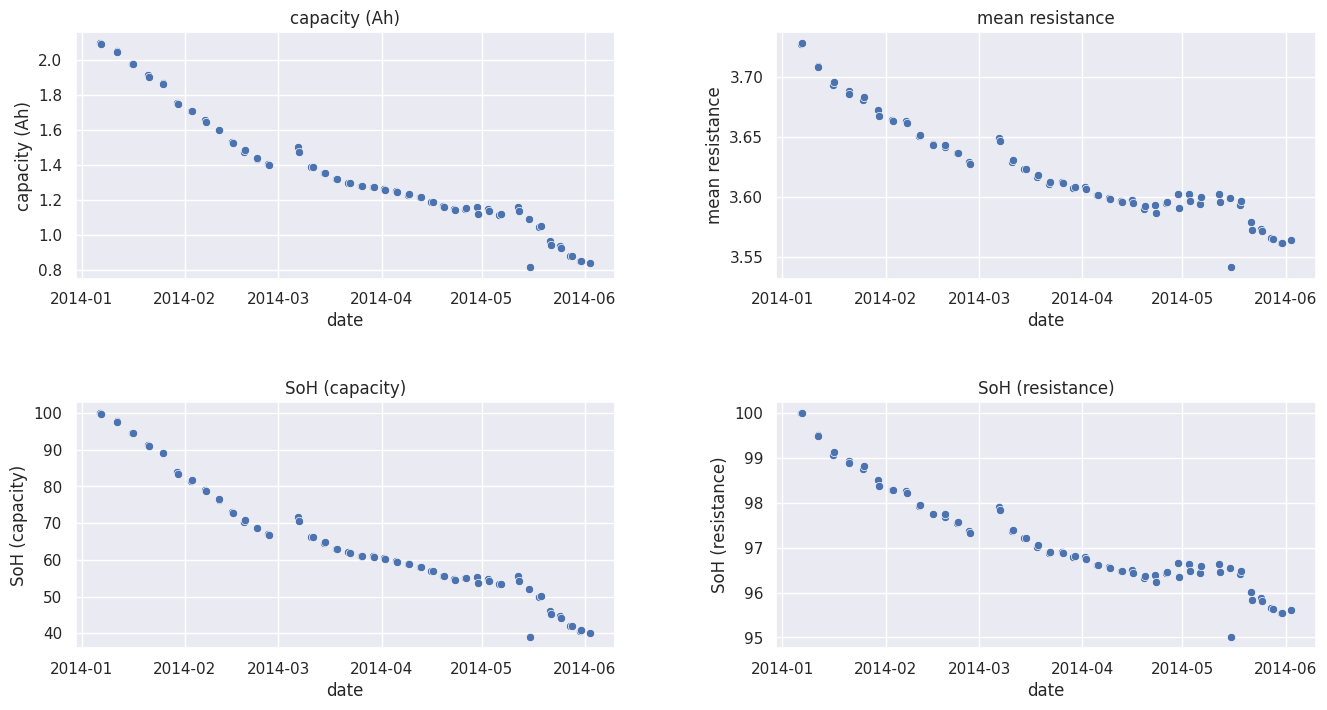

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

sns.set_style('darkgrid')
axes[0,0].set_title('capacity (Ah)')
axes[0,1].set_title('mean resistance')

sns.scatterplot(data=df, x='date', y='capacity (Ah)', ax=axes[0,0])
sns.scatterplot(data=df, x='date', y='mean resistance', ax=axes[0,1])


axes[1,0].set_title('SoH (capacity)')
axes[1,1].set_title('SoH (resistance)')
sns.scatterplot(data=df, x='date', y='SoH (capacity)', ax=axes[1,0])
sns.scatterplot(data=df, x='date', y='SoH (resistance)', ax=axes[1,1])

plt.subplots_adjust(wspace=0.3, hspace=0.5)

plt.show()

/tmp/ipykernel_42453/1826851206.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sm)


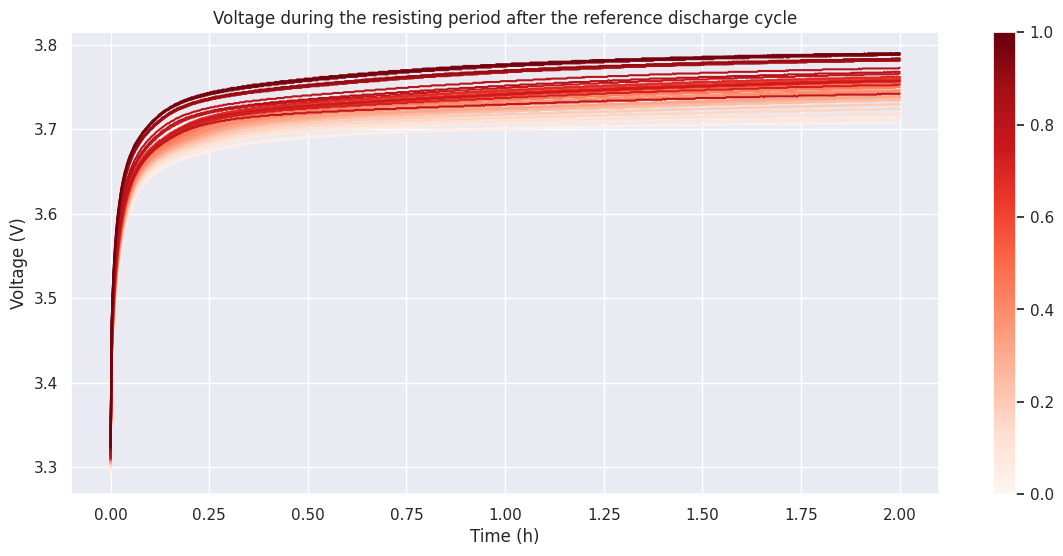

In [11]:
df = pd.DataFrame(mat['data']['step'])
df = df.query('comment == "rest post reference discharge"')
df = df[['relativeTime', 'voltage']]

sns.set(rc={"figure.figsize":(14, 6)}) 
sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("Reds", n_colors=len(df)))
cmap = sns.color_palette("Reds", n_colors=len(df), as_cmap=True)

for index, row in df.iterrows():
    time_hour = row['relativeTime'] / 3600
    voltage = row['voltage']
    sns.lineplot(x=time_hour, y=voltage, linewidth=1.5)


sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm)
plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')
plt.title('Voltage during the resisting period after the reference discharge cycle')
plt.show()
sns.reset_defaults()


## `mergeConsDf()` is a function to merge several cycles togheter

In [12]:
def mergeConsDf(df):
    temp_dict = {
        'voltage': [],
        'relativeTime': [],
        'date': [],
        }
    
    relative_acc_time = 0
    for _, row in temp_df.iterrows():
        temp_dict['voltage'].extend(row['voltage'])
        temp_dict['relativeTime'].extend(row['relativeTime'] + relative_acc_time)
        temp_dict['date'].extend([row['date'] for _, _ in enumerate(row['relativeTime'])])
        relative_acc_time = temp_dict['relativeTime'][-1]
    
    return pd.DataFrame(temp_dict)

/tmp/ipykernel_42453/3634422072.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  inds_list = np.array([inds for inds in inds_list if len(inds)!=1])


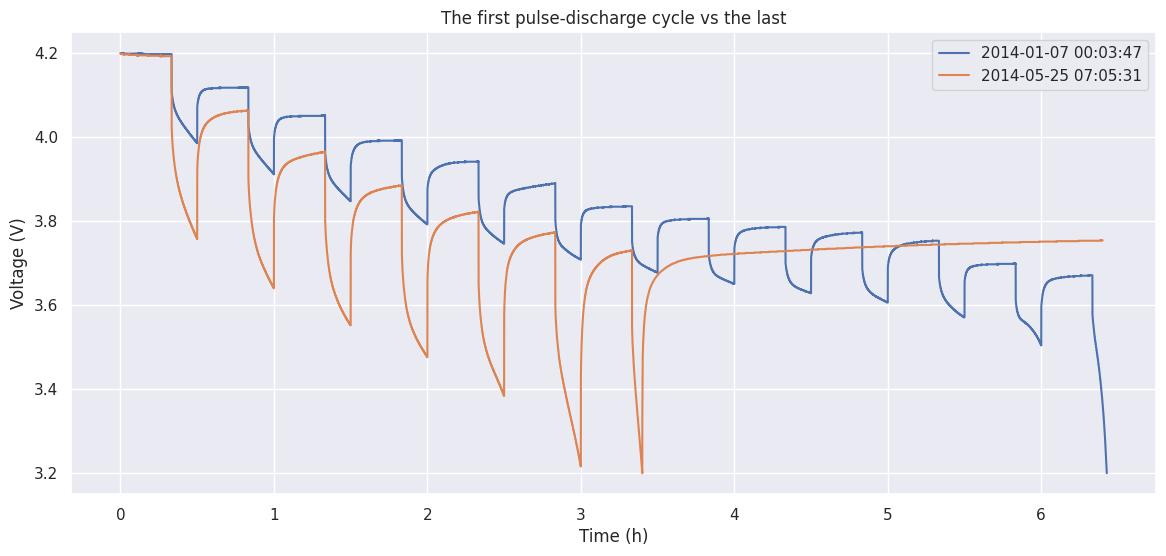

In [13]:
df = pd.DataFrame(mat['data']['step'])
df = df.query('comment in ["pulsed load (rest)", "pulsed load (discharge)", "rest post pulsed load or charge"]')

format_string = "%d-%b-%Y %H:%M:%S"
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, format_string)) # Change 'date' to the right format 

last_idx = None
inds_list = []
inds = []

for idx, row in df.iterrows():
    
    if not last_idx:
        last_idx=idx
    
    if abs(last_idx - idx) > 1:
        inds_list.append(inds)
        inds = []
    
    inds.append(idx)
    last_idx=idx

inds_list = np.array([inds for inds in inds_list if len(inds)!=1])
merged_list = []

for inds in inds_list:
    temp_df = df.loc[inds]
    temp_df = mergeConsDf(temp_df)
    merged_list.append(temp_df)


merged_list = merged_list[::len(merged_list)-1]
dates = []
sns.set_style('darkgrid')
sns.set(rc={"figure.figsize":(14, 6)}) 
for df in merged_list:
    time_hour = df['relativeTime'] / 3600
    voltage = df['voltage']
    # plt.plot(time_hour, voltage, linewidth=1.5, )
    ax = sns.lineplot(x=time_hour, y=voltage, linewidth=1.5)
    dates.append(df['date'][0])

sns.set(rc={"figure.figsize":(14, 6)})
plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')
plt.legend(dates)
plt.title('The first pulse-discharge cycle vs the last')
plt.show()


/tmp/ipykernel_42453/3208946796.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  inds_list = np.array([inds for inds in inds_list if len(inds)!=1])


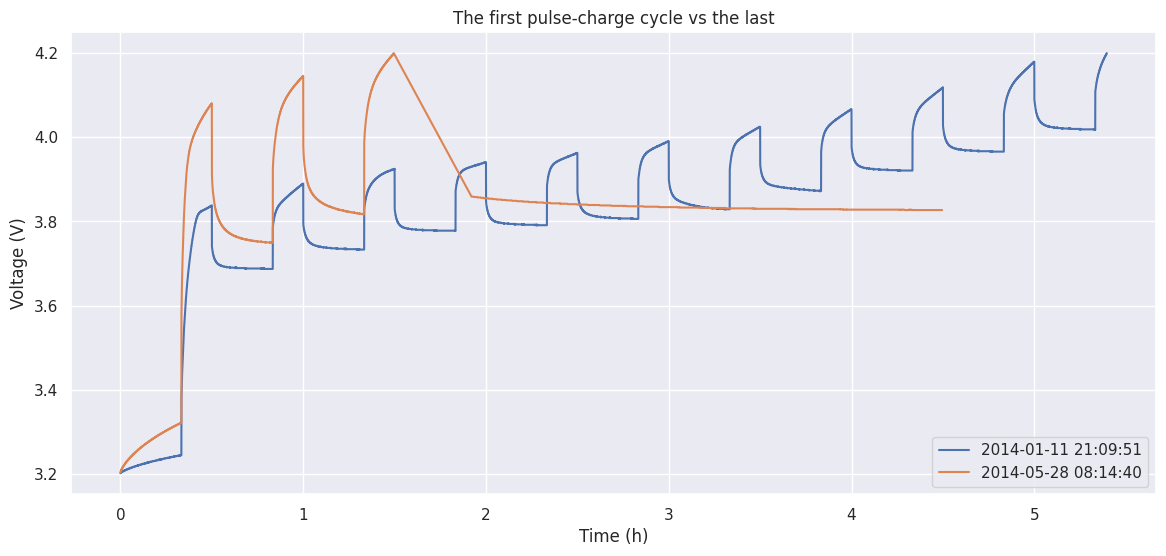

In [14]:
df = pd.DataFrame(mat['data']['step'])
df = df.query('comment in ["pulsed charge (rest)", "pulsed charge (charge)", "rest post pulsed load or charge"]')

format_string = "%d-%b-%Y %H:%M:%S"
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, format_string)) # Change 'date' to the right format 

last_idx = None
inds_list = []
inds = []

for idx, row in df.iterrows():
    
    if not last_idx:
        last_idx=idx
    
    if abs(last_idx - idx) > 1:
        inds_list.append(inds)
        inds = []
    
    inds.append(idx)
    last_idx=idx

inds_list = np.array([inds for inds in inds_list if len(inds)!=1])
merged_list = []

for inds in inds_list:
    temp_df = df.loc[inds]
    temp_df = mergeConsDf(temp_df)
    merged_list.append(temp_df)


merged_list = merged_list[::len(merged_list)-1]
dates = []
sns.set_style('darkgrid')
for df in merged_list:
    time_hour = df['relativeTime'] / 3600
    voltage = df['voltage']
    # plt.plot(time_hour, voltage, linewidth=1.5, )
    ax = sns.lineplot(x=time_hour, y=voltage, linewidth=1.5)
    dates.append(df['date'][0])

sns.set(rc={"figure.figsize":(14, 6)})
plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')
plt.legend(dates)
plt.title('The first pulse-charge cycle vs the last')
plt.show()


## Temperature

I'm curious about the distribution of the temperature for the different `type`s, hence I made this histogram, which showed that the temperature seemd normally distributed with no apparent skewness.

In [15]:
# df = pd.DataFrame(mat['data']['step'])
# temp_dict = {
#     'temperature': [],
#     'type': [],
# }

# for _, row in df.iterrows():
#     t = row['temperature']

#     if isinstance(t, np.ndarray):
#         temp_dict['temperature'].extend(t)
#         temp_dict['type'].extend([row['type'] for _ in range(len(t))])
        
#     elif isinstance(t, float):
#         temp_dict['temperature'].append(t)
#         temp_dict['type'].append(row['type'])

# df = pd.DataFrame(temp_dict)

# sns.set(rc={"figure.figsize":(14, 6)})
# sns.set_style('darkgrid')
# sns.histplot(data=temp_dict, x='temperature', hue='type', kde=True, bins=25)
# plt.title('Battery temperature distribution')
# plt.show()
# sns.reset_defaults()

In [16]:
format_string = "%d-%b-%Y %H:%M:%S"
df = pd.DataFrame(mat['data']['step'])
df = df.query('date.str.len()==20')
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, format_string)) # Change 'date' to the right format 
df['temperature'] = df['temperature'].apply(lambda x: x.mean() if isinstance(x, np.ndarray) else x)

## Temperature over time

I want to investigate how the temperature changes over time, seems that the overall temperature increases with time

In [17]:
# %matplotlib widget
# sns.set(rc={"figure.figsize":(14, 6)})
# sns.set_style('darkgrid')
# sns.lineplot(data=df, x='date', y='temperature', hue='type')
# plt.title('Mean temperature change over time')
# plt.show()

In [18]:
# %matplotlib widget
# sns.set_style('darkgrid')
# sns.relplot(data=df, x='date', y='temperature', col='type', kind='line')
# plt.suptitle('Mean temperature change over time')
# plt.show()

## Aggregate the data
This code below aggrgates the original raw data. For most part, it summerize the time-serie in each cycle to create a more coarse grain time-serie

In [19]:

format_string = "%d-%b-%Y %H:%M:%S"
date_format_string = '%d-%b-%Y'

df = pd.DataFrame(mat['data']['step'])

df_ref = df.query('comment=="reference discharge"')
df_ref = df_ref.query('comment == "reference discharge"')
df_ref['date'] = df_ref['date'].apply(lambda x: datetime.strptime(x, format_string)) # Change 'date' to the right format 
df_ref['capacity (Ah)'] = [np.trapz(i, t) / 3600 for i, t in zip(df_ref['current'], df_ref['relativeTime'])] # Performing the integral
df_ref['gt'] = True

df = df.query('date.str.len()==20')
df['dateTime'] = df['date'].apply(lambda x: datetime.strptime(x, format_string)) # Change 'date' to the right format 
df['date'] = df['dateTime'].apply(lambda x: x.date()) 
df['time'] = df['time'].apply(lambda x: x if isinstance(x, np.ndarray) else np.array([x]))
df['voltage'] = df['voltage'].apply(lambda x: x if isinstance(x, np.ndarray) else np.array([x]))
df['current'] = df['current'].apply(lambda x: x if isinstance(x, np.ndarray) else np.array([x]))
df['timeRange'] = df['relativeTime'].apply(lambda x: x[-1] if isinstance(x, np.ndarray) else x)
df['avgTemperature'] = df['temperature'].apply(lambda x: np.mean(x))
df['avgCurrent'] = df['current'].apply(lambda x: np.mean(x))
df['avgVoltage'] = df['voltage'].apply(lambda x: np.mean(x))

df['avgResistance'] = df['avgCurrent'] / df['avgVoltage']

df['startVoltage'] = df['voltage'].apply(lambda x: x[0])
df['terminalVoltage'] = df['voltage'].apply(lambda x: x[-1])
df['deltaVoltage'] = df['terminalVoltage'] - df['startVoltage']
df['rateOfVoltage'] = (df['deltaVoltage'] / df['timeRange']) / 3600 
df = df.join(df_ref[['capacity (Ah)', 'gt']], how='left')
df['gt'] = df['gt'].notna()
df['endTime'] = df['time'].apply(lambda x: x[-1]) / 3600
df['cycle'] = df.index

mean_df = df.groupby(['date'])[['avgTemperature']].var().reset_index()
df = df.merge(mean_df, on=['date'], suffixes=('Cycle', 'Daily'))

df = df[['comment',
         'type', 
         'dateTime',
         'date',
         'endTime',
         'timeRange',
         'avgTemperatureCycle',
         'avgTemperatureDaily', 
         'avgVoltage',
         'avgCurrent',
         'avgResistance',
         'startVoltage',
         'terminalVoltage',
         'deltaVoltage',
         'rateOfVoltage',
         'gt',
         'cycle',
         'capacity (Ah)',
         ]]


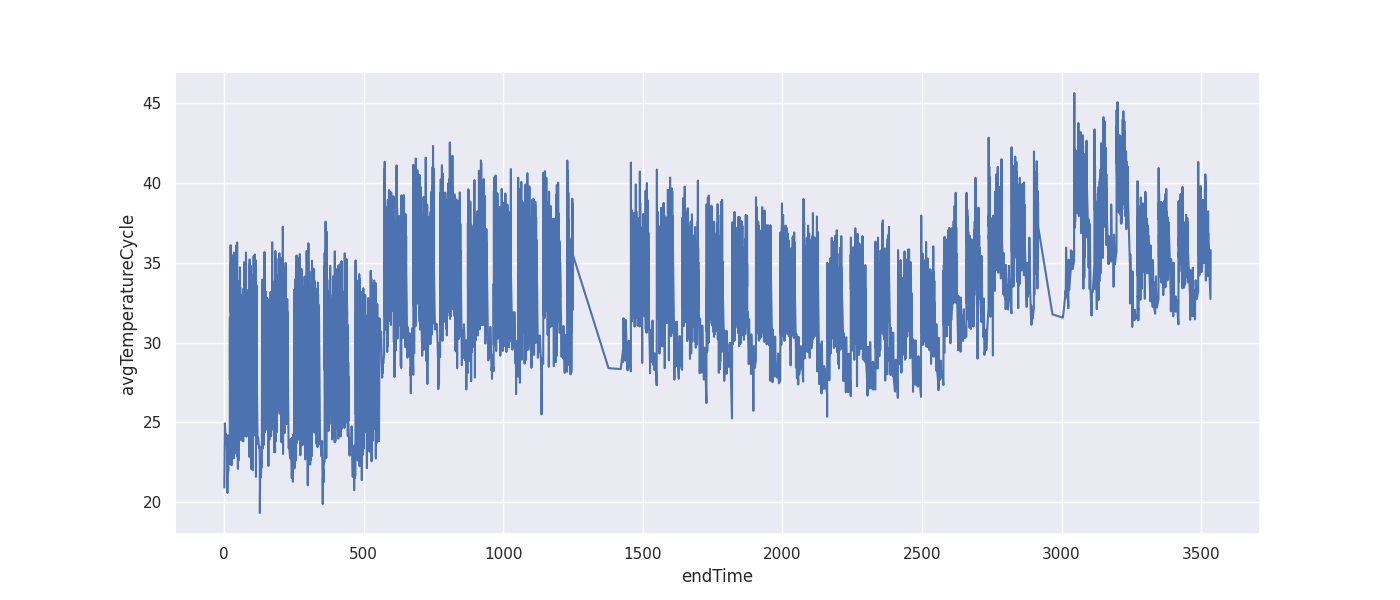

In [20]:
%matplotlib widget
sns.set(rc={"figure.figsize":(14, 6)}) 
sns.lineplot(data=df, x='endTime', y='avgTemperatureCycle')
plt.show()

## Interpolate the ground-truth

Since only the **reference-discharge** data (80 data points) have ground-truth, I choose to interpolate the rest of the values, due to the necessity for computing the correlational matrix later.

`gt=True` are the original points, while `gt=False` are the points obtained from the interpolation

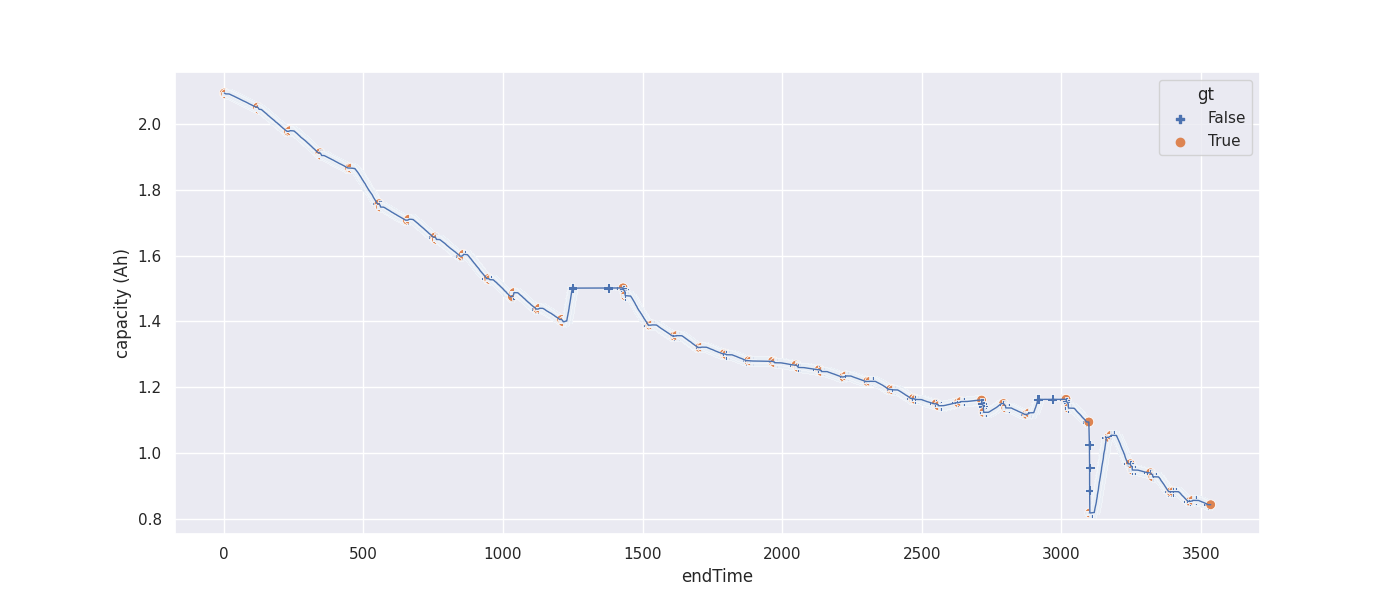

In [21]:
# Interpolation
df['capacity (Ah)'] = df.set_index('endTime')['capacity (Ah)'].interpolate(method='linear').reset_index().dropna()['capacity (Ah)']
# Let's compute the SoH while we're at it
df['SoH'] = df['capacity (Ah)'] / df.dropna()['capacity (Ah)'].iloc[0] * 100

%matplotlib widget
sns.set(rc={"figure.figsize":(14, 6)}) 
plt.rcParams['lines.linewidth'] = 1

sns.set_style('darkgrid')
sns.lineplot(data=df, y='capacity (Ah)', x='endTime')
sns.scatterplot(data=df, y='capacity (Ah)', x='endTime', hue='gt', style='gt', markers=['P', 'o'], s=50)
plt.show()

## The result from the interpolation



## Correlational matrix for **Feature Selection**

This part is for identifying the relevant variables, we will look at the 3 charge types (charge, discharge and rest) combined and also the types separately. Furthermore, we also filter out the reference charge and discharge since those are not to realistic. There also a bunch of super-small charge and discharges, which tends to be very noise, which I also filter out.

### Discovery

#### All cycles

- The poorly named `endTime` is the absolute time (in hour) from the first cycle, where each cycle ends. `endTime` and `cycle` (which are related), turns out to be highly correlated with `SoH`, which makes sense, since in way it indicates the age of the battery.
- The `averageTemperatureDaily` and `averageTemperatureCyle` is also highly relevant, perhaps since the battery gets heated quicker when older. This was a bit unexpected and I wonder it's this still holds true for enviroment with more variable ambient temperature, e.g. in more realistic scenarios.
- The voltage played a far less roll here than expected.

#### Charge cycle

- Similar to **All cycles** `endTime`, `cycles`, `averageTemperatureDaily` and `averageTemperatureCyle` are relevant features. 
- For charging, it seems that `avgCurrent` and  `avgResistance` are also very relevant.
- features such as `rateOfVoltage` seeem also somewhat relevant, although it's not striking.

#### Discharge cycle

- Similar to the **Charge cycles** but the `rateOfVoltage` seem to be of more importance than the other for example the `avgResistance`

#### Rest cycle

- The `deltaVoltage` and the `timeRange` seem to be relevant for this cycle type

<Figure size 2000x1000 with 0 Axes>

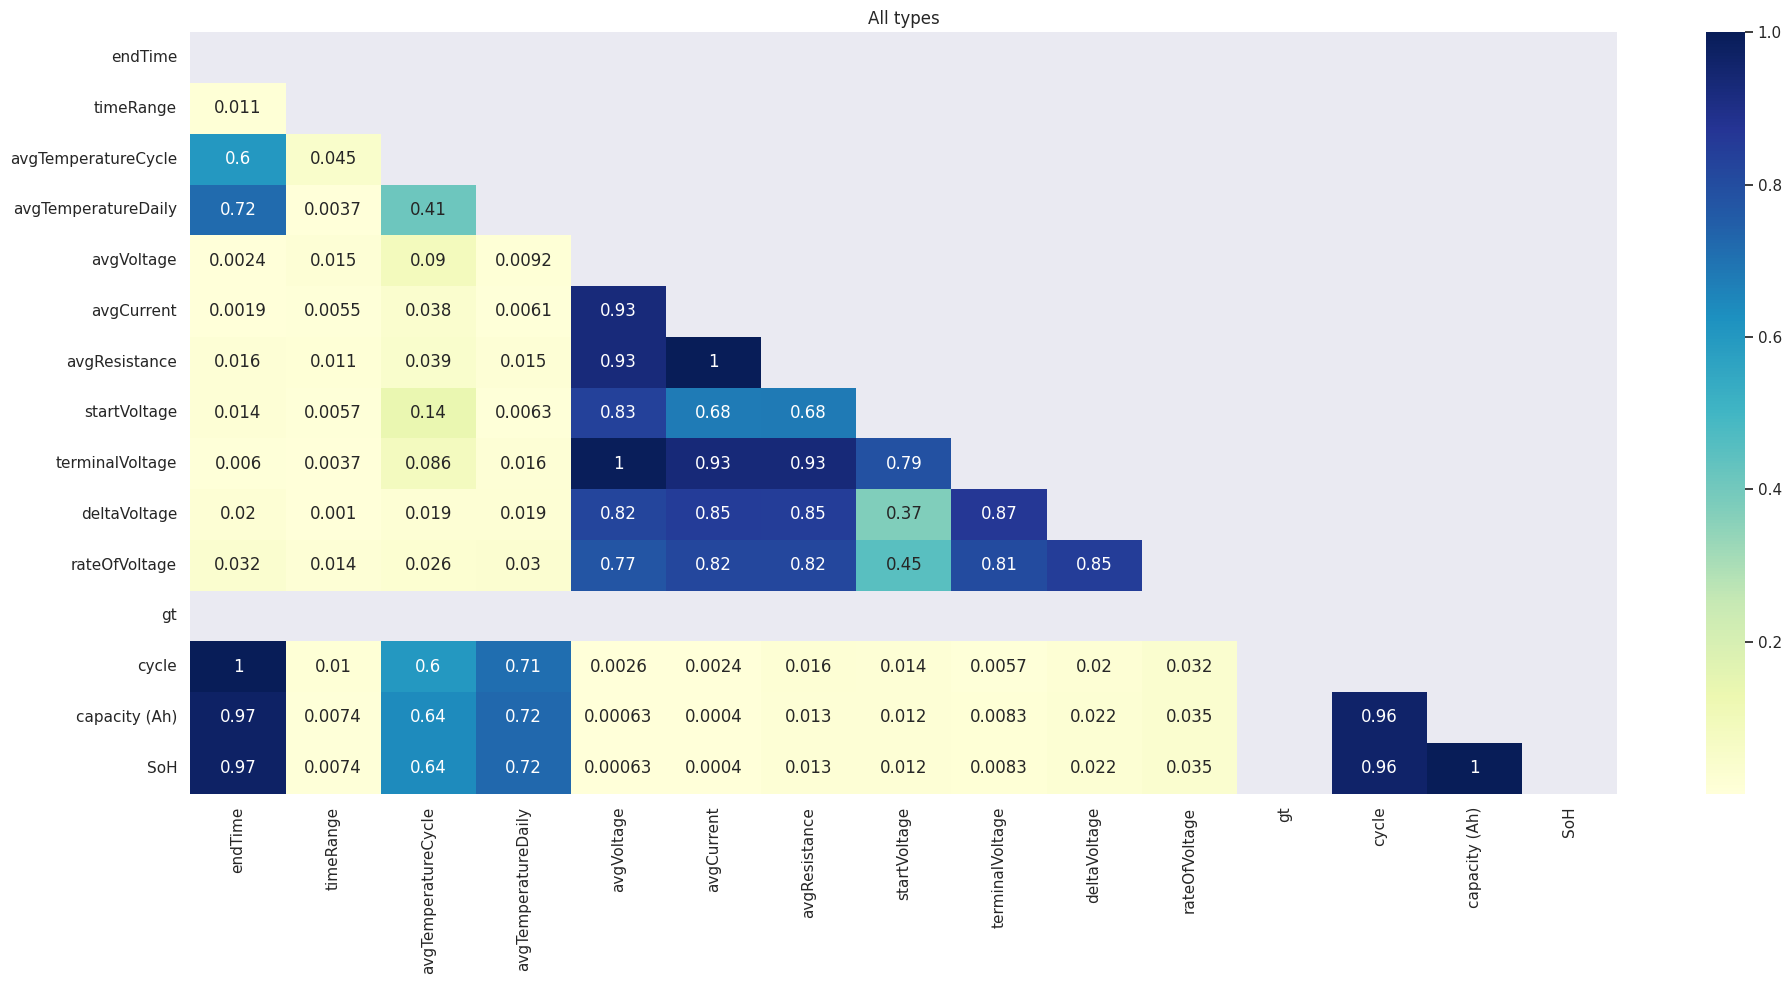

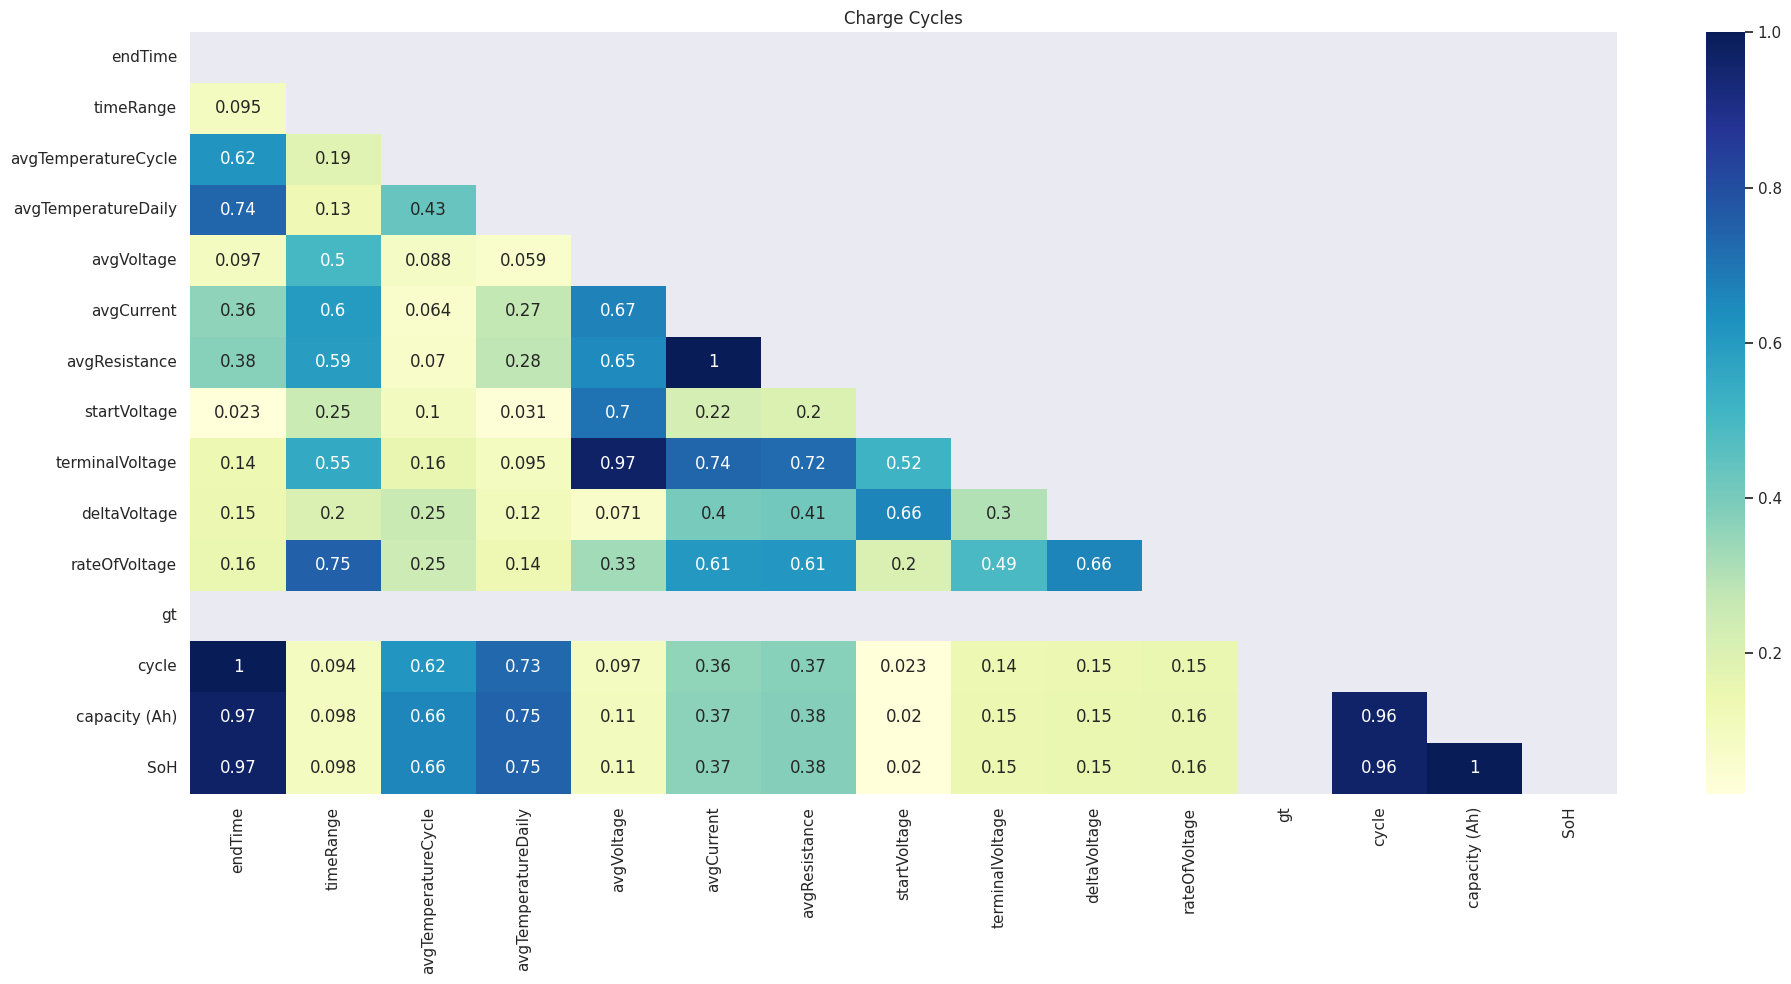

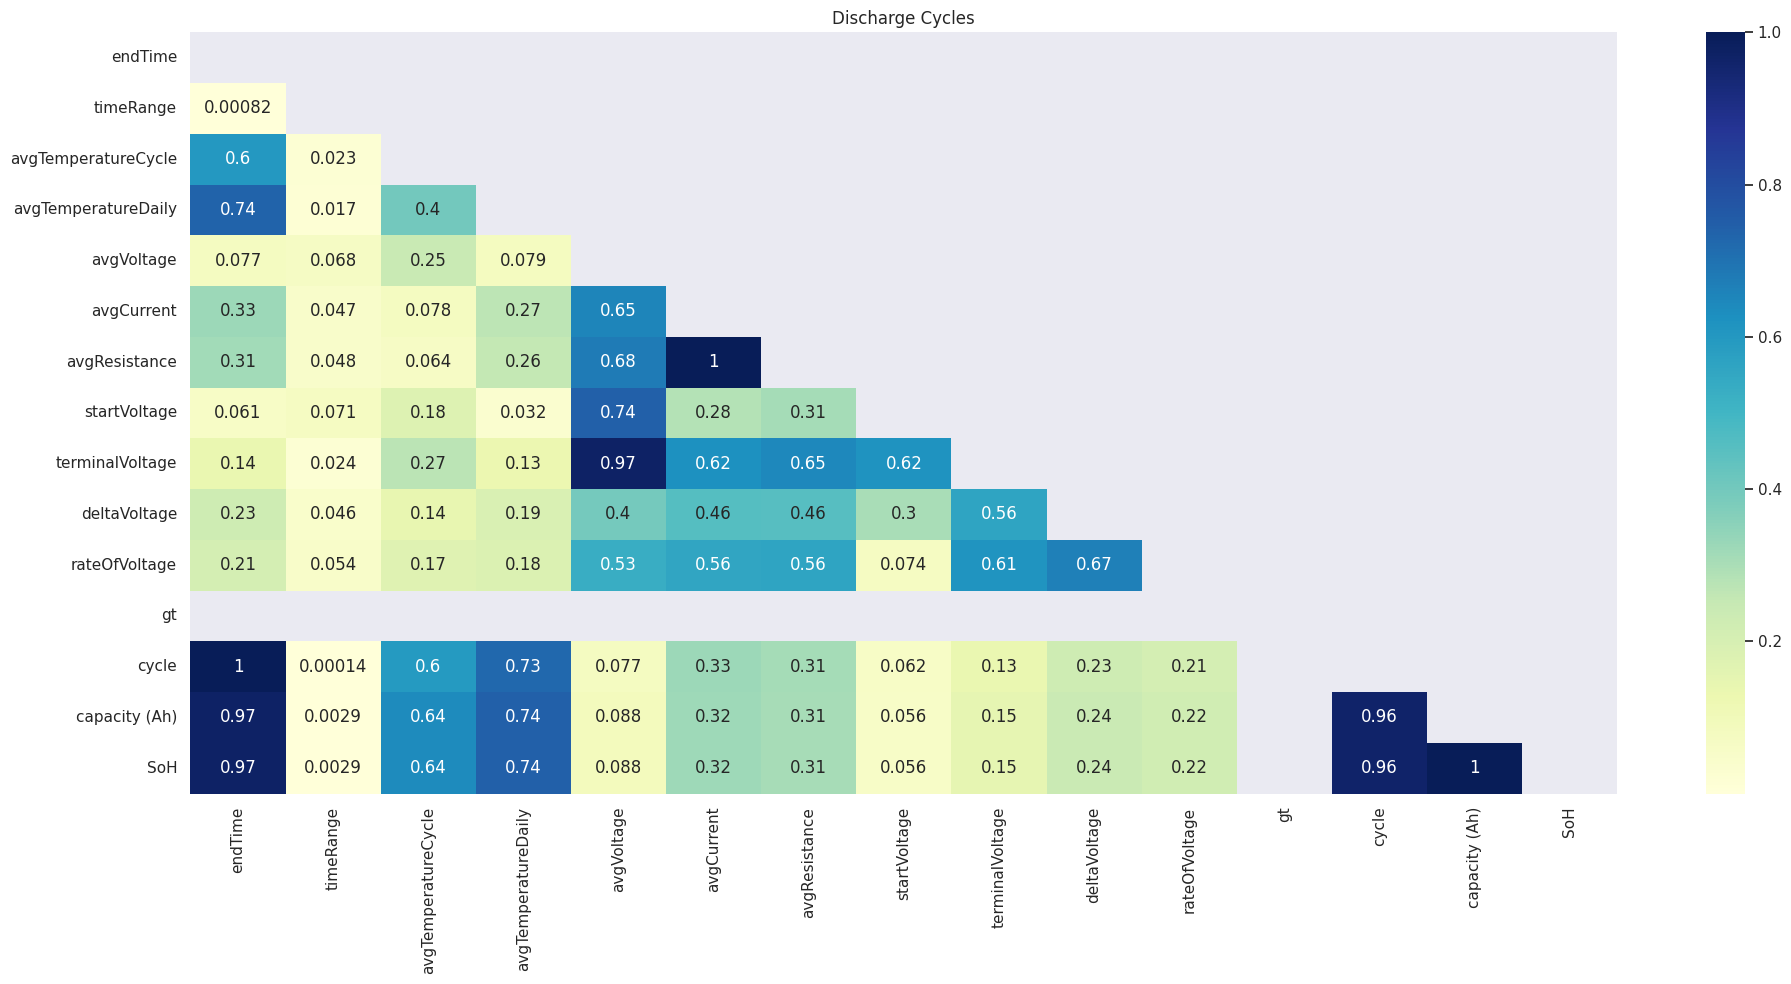

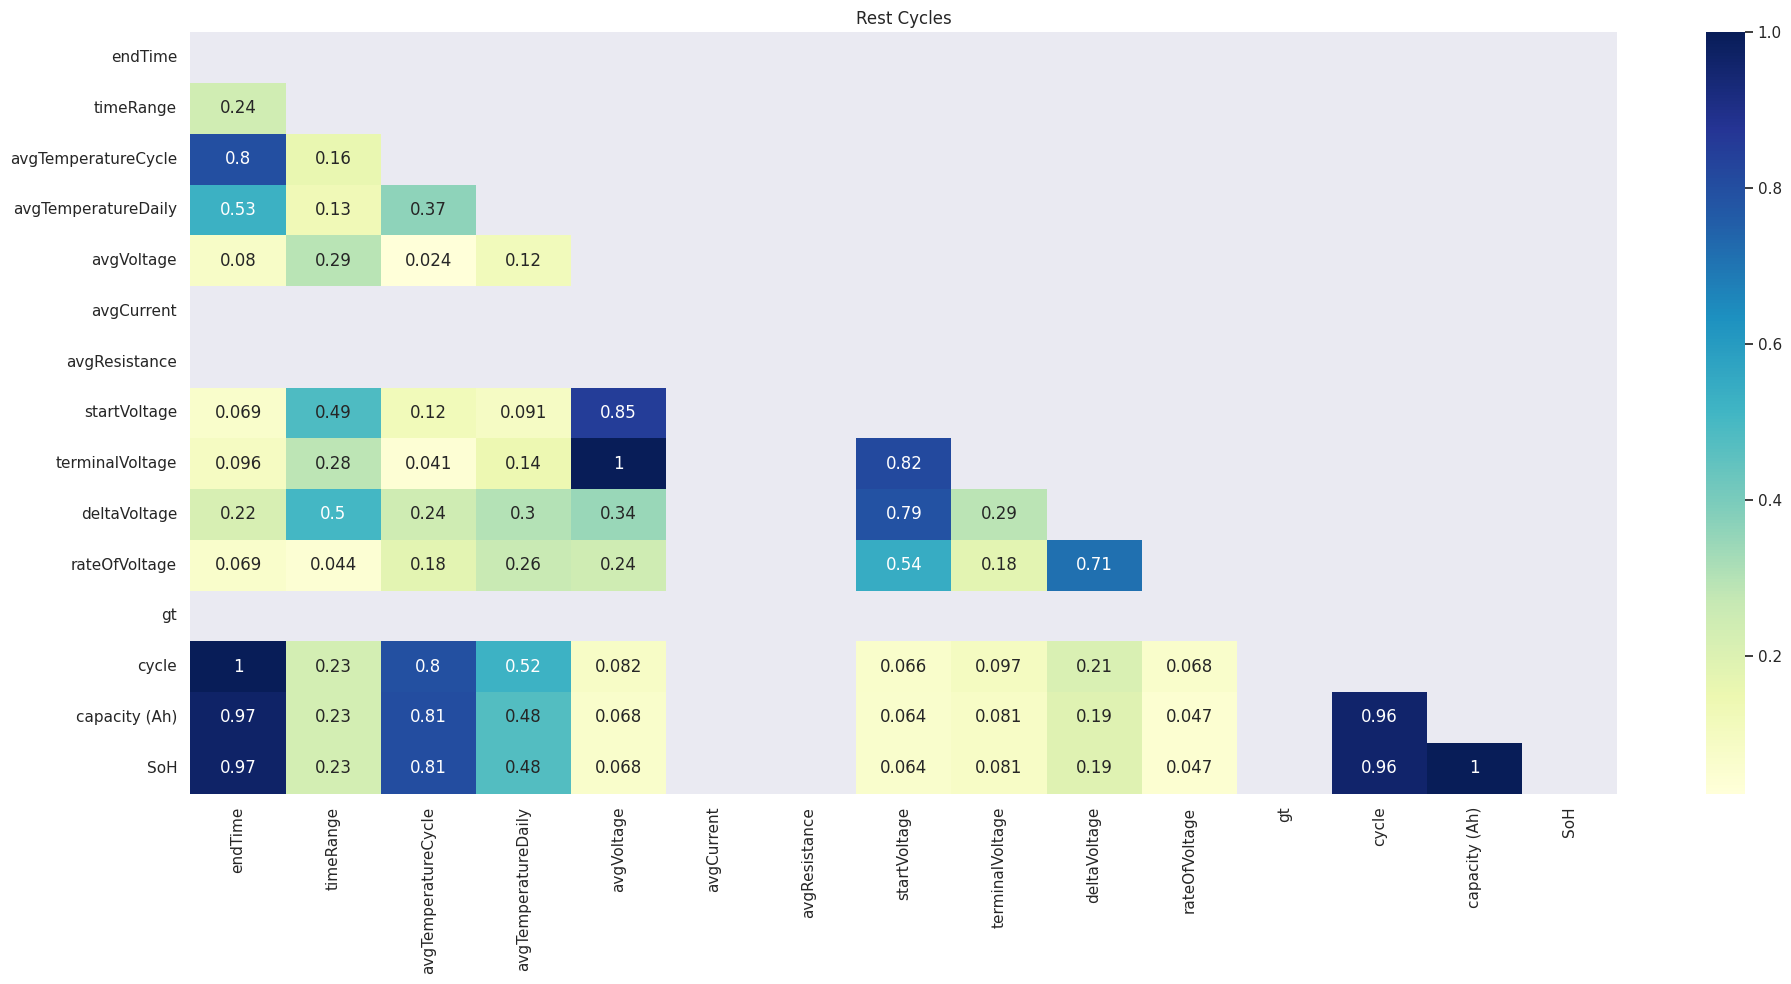

<Figure size 2000x1000 with 0 Axes>

In [22]:
%matplotlib inline
height, width = 10, 20

sns.set(rc={"figure.figsize":(width, height)})
corr_mat = df.query('comment not in ["reference discharge", "reference charge"] and timeRange>60').corr().abs()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
dataplot = sns.heatmap(corr_mat, cmap="YlGnBu", annot=True, mask=mask)
plt.title('All types')
plt.tight_layout()
plt.figure()

sns.set(rc={"figure.figsize":(width, height)})
corr_mat = df.query('type=="C" and comment not in ["reference discharge", "reference charge"] and timeRange>60').corr().abs()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
dataplot = sns.heatmap(corr_mat, cmap="YlGnBu", annot=True, mask=mask)
plt.title('Charge Cycles')
plt.tight_layout()
plt.figure()

sns.set(rc={"figure.figsize":(width, height)})
corr_mat = df.query('type=="D" and comment not in ["reference discharge", "reference charge"] and timeRange>60').corr().abs()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
dataplot = sns.heatmap(corr_mat, cmap="YlGnBu", annot=True, mask=mask)
plt.title('Discharge Cycles')
plt.tight_layout()
plt.figure()

sns.set(rc={"figure.figsize":(width, height)})
corr_mat = df.query('type=="R" and comment not in ["reference discharge", "reference charge"] and timeRange>60').corr().abs()
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
dataplot = sns.heatmap(corr_mat, cmap="YlGnBu", annot=True, mask=mask)
plt.title('Rest Cycles')
plt.tight_layout()
plt.figure()